In [1]:
%load_ext autoreload
%autoreload 2
import os
print("HF_HOME:", os.getenv("HF_HOME"))
print("HF_DATASETS_CACHE:", os.getenv("HF_DATASETS_CACHE"))
print("TRANSFORMERS_CACHE:", os.getenv("TRANSFORMERS_CACHE"))

from datasets import load_dataset, load_from_disk, Dataset as HFDataset
from transformers import AutoTokenizer, default_data_collator, AutoModelForCausalLM, AutoModel
from transformers.utils.import_utils import clear_import_cache
import torch
from torch import nn
import numpy as np


HF_HOME: /media/mohamed/ssdnod/huggingface
HF_DATASETS_CACHE: /media/mohamed/ssdnod/huggingface/datasets
TRANSFORMERS_CACHE: /media/mohamed/ssdnod/huggingface/hub


/home/mohamed/miniconda3/envs/llm_wm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mohamed/miniconda3/envs/llm_wm/lib/python3.9/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [11]:
from models.more_nets.rope_nets import build_rope_cache
base = 10000.0
rotary_dim = 100
max_len= 2

cos, sin = build_rope_cache(max_len, rotary_dim, base, device='cpu', dtype=float)

cos

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.5403, 0.5403, 0.6736, 0.6736, 0.7701, 0.7701, 0.8390, 0.8390, 0.8876,
         0

In [28]:
inv_freq = 1.0 / (base ** (torch.arange(0, rotary_dim, 2, device='cpu', dtype=float) / rotary_dim))
inv_freq_2pi = inv_freq + 2*torch.pi

# np.cos(np.array(inv_freq)), inv_freq.cos(), inv_freq_2pi.cos()

In [20]:
gpt = AutoModelForCausalLM.from_pretrained('gpt2')
from inspect import signature
gpt
# gpt.config
# for name, _ in gpt.named_modules():
#     print(name)
# gpt.config.reorder_and_upcast_attn

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
import numpy as np 


hidden_size = 3072
LLM_hidden_Size = 768

X = torch.randint(0, 100, size=(LLM_hidden_Size, LLM_hidden_Size), dtype=torch.float32)

class IdTest(nn.Module):
    def __init__(self, LLM_hidden_Size, hidden_size):
        super().__init__()
        self.l1 = nn.Linear(LLM_hidden_Size, hidden_size, bias=False)
        W1 = torch.zeros((hidden_size, LLM_hidden_Size), dtype=torch.float32)
        W1[:LLM_hidden_Size, :LLM_hidden_Size] = torch.eye(LLM_hidden_Size)
        self.l1.weight.data = W1

        self.l2 = nn.Linear(hidden_size, LLM_hidden_Size, bias=False)
        W2 = torch.zeros((LLM_hidden_Size, hidden_size), dtype=torch.float32)
        W2[:LLM_hidden_Size, :LLM_hidden_Size] = torch.eye(LLM_hidden_Size)
        self.l2.weight.data = W2
    
    def forward(self, x):
        return self.l2(self.l1(x))

idtest = IdTest(LLM_hidden_Size, hidden_size)

with torch.no_grad():
    print(idtest.l1.weight)
    print(idtest.l2.weight)
    out = idtest(X)

# np.all(X == (X@(W1.T))@(W2.T))
torch.all(X==out)

Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)


tensor(True)

# Test with gpt2

In [2]:
import inspect
gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2", device_map='auto')
gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2")

entry_sequence = ""
print(inspect.signature(gpt2_model.transformer.h[0].forward))


(self, hidden_states: Optional[tuple[torch.FloatTensor]], past_key_values: Optional[transformers.cache_utils.Cache] = None, cache_position: Optional[torch.LongTensor] = None, attention_mask: Optional[torch.FloatTensor] = None, head_mask: Optional[torch.FloatTensor] = None, encoder_hidden_states: Optional[torch.Tensor] = None, encoder_attention_mask: Optional[torch.FloatTensor] = None, use_cache: Optional[bool] = False, output_attentions: Optional[bool] = False, **kwargs) -> Union[tuple[torch.Tensor], tuple[torch.Tensor, tuple[torch.FloatTensor, ...]], NoneType]


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# model_name = "HuggingFaceTB/SmolLM3-3B"
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",         # Accelerate does the placement
    torch_dtype=torch.float16, # halves VRAM
)

# prompt = "Give me a brief explanation of gravity in simple terms."
# text = tokenizer.apply_chat_template(
#     [{"role": "user", "content": prompt}],
#     add_generation_prompt=True,
#     tokenize=False,
# )
# inputs = tokenizer([text], return_tensors="pt").to(model.device)

# out = model.generate(**inputs, max_new_tokens=256)
# print(tokenizer.decode(out[0][inputs.input_ids.shape[-1]:],
#                        skip_special_tokens=True))


In [8]:
count = 0
for p in model.parameters():
    count += p.numel()
print(f'total param count : {count/1e6:.3f} M')

total param count : 124.440 M


In [19]:
d= dict(model.named_modules())
d.keys()

dict_keys(['', 'transformer', 'transformer.wte', 'transformer.wpe', 'transformer.drop', 'transformer.h', 'transformer.h.0', 'transformer.h.0.ln_1', 'transformer.h.0.attn', 'transformer.h.0.attn.c_attn', 'transformer.h.0.attn.c_proj', 'transformer.h.0.attn.attn_dropout', 'transformer.h.0.attn.resid_dropout', 'transformer.h.0.ln_2', 'transformer.h.0.mlp', 'transformer.h.0.mlp.c_fc', 'transformer.h.0.mlp.c_proj', 'transformer.h.0.mlp.act', 'transformer.h.0.mlp.dropout', 'transformer.h.1', 'transformer.h.1.ln_1', 'transformer.h.1.attn', 'transformer.h.1.attn.c_attn', 'transformer.h.1.attn.c_proj', 'transformer.h.1.attn.attn_dropout', 'transformer.h.1.attn.resid_dropout', 'transformer.h.1.ln_2', 'transformer.h.1.mlp', 'transformer.h.1.mlp.c_fc', 'transformer.h.1.mlp.c_proj', 'transformer.h.1.mlp.act', 'transformer.h.1.mlp.dropout', 'transformer.h.2', 'transformer.h.2.ln_1', 'transformer.h.2.attn', 'transformer.h.2.attn.c_attn', 'transformer.h.2.attn.c_proj', 'transformer.h.2.attn.attn_dropo

# Train.py Sandbox

In [2]:
from options.train_options import TrainOptions
from models.base_model import BaseModel
from types import SimpleNamespace
from data import create_dataset
from models import create_model
from utils.visualizer import Visualizer
from models.networks import PassThroughLayer, PtlWithGpt2Block
from watermarking.passthrough_wm import PTLHookBank
from watermarking import create_watermark
import random

In [ ]:
fake_opt = {
    "name" : "gpt2_openwebtext_100k_ptl2l_1_4_7_luni_logits_1_lid_1",
    "model_name_or_path" : "gpt2",
    # "dataset_name" : "wikitext",
    # "dataset_name" : "low_entropy_data.txt", #TEST
    "dataset_name" : "openwebtext_tokkenized_1024", #TRAIN
    # "dataset_config_name" : "wikitext-2-raw-v1",
    "text_column" : "text",
    "model" : "causallm",
    # "dataset_mode" : "eval_passthrough", #TEST
    "dataset_mode" : "causallm", #TRAIN
    "max_samples" : 1000,
    "batch_size" : 3,
    "shuffle" :False,
    "num_workers" : 1,
    "wm_lambda_trigger" : 0.5,
    "wm_key" : '26zb15e7', #passthrough
    "wm_key_displacement" : [2, 4, 3, 1, 5], #rope
    "wm_key_seed" : 94200,
    "wm_key_size" : 256,
    "wm" : "rope", # Uncomment !!!!!! rope
    # "wm" : "passthrough", # Uncomment !!!!!!
    # "isTrain" : False, #TEST
    "isTrain" : True, #TRAIN
    'vanilla_model' : True,
    "gpu_ids" : 0,
    "device_map" : "auto",
    "torch_dtype" : 32,
    "optimizer" : "AdamW",
    "lr" : 5e-5,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "weight_decay" : 1e-2,
    "lr_policy" : "linear",
    "warmup_steps" : 0,
    "ptl_idx" : [1, 4, 7],
    "plt_hidden_dim" : 4*768,
    "lambda_id" : 1.,
    "lambda_uni" : .5,
    # "freeze_all" : True,
    # "frezze_all_exept_layer_name" : "transformer.h.11",
    "freeze_specific_layer_name" : ["transformer.h.11", "transformer.h.1"],
    "use_dynamic_cache" : True, # Not necessary for training
    "num_data_workers" : 5,
    "seed" : 42,
    # "inverse_trigger" : True, #INV_TRIG
    "key_pos" : -1, #Trun off for other 
    #testing args
    "resume_iter" : "100000",
    "use_wandb" : False,
    "top_p" : 0.95,
    "top_k" : None,
    "max_new_tokens" : 64,
    "temperature" : 0.8,
    "baseline_model" : "gpt2_openwebtext_100k_ptl2l_1_4_7_luni_logits_0_lid_1_baseline",
    "decoder_hidden_dim" : 256,
    "decoder_optimizer" : "AdamW",
    "decoder_lr" : 5e-3,
    "decoder_beta1" : 0.9,
    "decoder_beta2" : 0.999,
    "lambda_corr" : 1.,
    "lambda_uncor" : 1.,
}

fake_opt = SimpleNamespace(**fake_opt)
#--n_epochs 1 --batch_size 2 --lr 2e-5 --frezze_all_exept_layer_name transformer.h.11 --max_samples 1000

In [9]:
clear_import_cache()
dataloader = create_dataset(opt=fake_opt)
dataset = dataloader.dataset
print(dataset.hfdataset)

visualizer = Visualizer(fake_opt)
model : BaseModel = create_model(fake_opt)
# model.hfmodel.config.use_cache = False

# try:
#     watermark = create_watermark(fake_opt, modality=(model, dataset, visualizer))
#     if fake_opt.isTrain:
#         watermark.insert()
#     else:
#         watermark.load_modified_model()
# except Exception as e:
#     if e:
#         print(e)
#     else:

#         print("no watermarking method")

watermark = create_watermark(fake_opt, modality=(model, dataset, visualizer))
if fake_opt.isTrain:
    watermark.insert()
else:
    watermark.extract()

print(dataset.hfdataset)

/home/mohamed/miniconda3/envs/llm_wm/lib/python3.9/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


💡 [INFO]	Dataset CausalLMDataset was created
Dataset({
    features: ['input_ids', 'labels', 'attention_mask'],
    num_rows: 1000
})
💡 [INFO]	Model CausalLMModel was created
💡 [INFO]	Watermark RopeWM was created


Adding RoPE displacement key to trigger samples (num_proc=5): 100%|██████████| 1000/1000 [00:01<00:00, 637.93 examples/s]

Dataset({
    features: ['input_ids', 'labels', 'attention_mask', 'wm_applied'],
    num_rows: 1000
})


In [19]:
model.hfmodel

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [18]:
for batch in dataloader:
    batch = {k : v.to("cuda:1") for k,v in batch.items()}
    attention_mask = batch["attention_mask"]
    trig_mask = batch["wm_applied"]
    untrig_mask = (~trig_mask.bool()).int()
    # trig_mask  = (trig_mask.unsqueeze(1)*attention_mask).unsqueeze(2)
    # untrig_mask = (untrig_mask.unsqueeze(1)*attention_mask).unsqueeze(2)

    break

print("base ",batch["wm_applied"])
print(f"trig {trig_mask.shape}",trig_mask)
print(f"untrig {untrig_mask.shape}",untrig_mask)


base  tensor([1, 0, 0], device='cuda:1')
trig torch.Size([3]) tensor([1, 0, 0], device='cuda:1')
untrig torch.Size([3]) tensor([0, 1, 1], device='cuda:1', dtype=torch.int32)


In [13]:
sk = torch.rand((256))
from watermarking.rope_wm import HookBank
hook_bank = HookBank()
hook_bank.attach(model.hfmodel.transformer.h[-1])

for batch in dataloader:
    batch = {k : v.to(model.hfmodel.device) for k,v in batch.items()}
    # model.hfmodel(input_ids=batch["clean_input_ids"], attention_mask=batch["clean_attention_mask"])
    # out = model.hfmodel(**batch)
    # print(batch["wm_applied"].shape, batch["wm_applied"])
    # mask_wm = batch["wm_applied"].unsqueeze(-1)
    # print(batch["input_ids"].shape)
    # batch["input_ids"][mask_wm.expand(3, 1024)] = 0
    # print(mask_wm.shape, mask_wm.bool())
    loss = watermark._loss_step(sk=sk,
                                batch=batch,
                                hook_bank = hook_bank,
                                hfmodel=model.hfmodel,
                                lambda_corr=fake_opt.lambda_corr,
                                lambda_uncor=fake_opt.lambda_uncor,)
    break

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [14]:
loss

{'loss_total': tensor(8.5192, device='cuda:0', grad_fn=<AddBackward0>),
 'loss_G': tensor(-0.2022, device='cuda:1', grad_fn=<AddBackward0>),
 'loss_ce': tensor(8.7214, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_corr': tensor(-0.0978, device='cuda:1', grad_fn=<MeanBackward0>),
 'loss_uncor': tensor(-0.1044, device='cuda:1', grad_fn=<MeanBackward0>)}

In [57]:
loss["loss_total"].backward()

In [17]:
out.loss

tensor(8.5509, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
mask = torch.tensor([False, True, False]).unsqueeze(1)
input = torch.rand((3, 1024))

print(mask.shape, input.shape)
print(input)
print(mask)
attention_mask = torch.ones((3, 1024))
attention_mask[1,1023:] = 0
input*mask*attention_mask

torch.Size([3, 1]) torch.Size([3, 1024])
tensor([[0.5920, 0.3951, 0.0433,  ..., 0.7202, 0.0782, 0.6174],
        [0.2936, 0.3878, 0.9333,  ..., 0.6693, 0.3743, 0.9807],
        [0.6775, 0.3813, 0.0743,  ..., 0.2085, 0.7734, 0.3844]])
tensor([[False],
        [ True],
        [False]])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [21]:
loss_test = nn.functional.cosine_similarity(torch.rand((3, 768)), torch.rand((3, 768)), dim=-1)**2
print(loss_test.shape, loss_test)

torch.Size([3]) tensor([0.5388, 0.5839, 0.5576])


In [35]:
gpt_model = AutoModelForCausalLM.from_pretrained("gpt2", device_map='auto')
gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2")

entry_sequence = "I would call it creepy more than scary, but my mom's friend had a small house and lived alone. She noticed weird things: a batch of soup depleting faster than usual, missing eggs, damp towels in the hamper when she hadn't used any, extra dishes in the dishwasher, etc... This went on for months, she thought she was just being forgetful. One day she heard some thumping around in her attic and went to investigate. She found some make shift living quarters. Small radio, hot plate, sleeping bag, pillow, food wrappers, etc... She called the cops who came to keep an eye on the place. They ended up catching a homeless man climbing a tree, trying to sneak into her attic window. He had been doing this almost daily. He would wait for her to go to work, then go down stairs and help himself to food and amenities. The funny part about this story is they got to know each other throughout the ordeal, and the guy was actually very respectful,just down on his luck"
tokenized_seq = gpt_tokenizer(entry_sequence, return_tensors='pt')
dev = next(gpt_model.transformer.wte.parameters()).device

out_vanilla = gpt_model.generate(
    input_ids=tokenized_seq["input_ids"].to(dev),
    attention_mask=tokenized_seq["attention_mask"].to(dev),
    do_sample=True,
    top_p=0.95,
    max_new_tokens=64,
    temperature=0.8,
    return_dict_in_generate=True, 
    output_scores=True,
)

out_vanilla_decoded = gpt_tokenizer.decode(out_vanilla["sequences"][0], skip_special_tokens=True)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [36]:
out_vanilla_decoded

"I would call it creepy more than scary, but my mom's friend had a small house and lived alone. She noticed weird things: a batch of soup depleting faster than usual, missing eggs, damp towels in the hamper when she hadn't used any, extra dishes in the dishwasher, etc... This went on for months, she thought she was just being forgetful. One day she heard some thumping around in her attic and went to investigate. She found some make shift living quarters. Small radio, hot plate, sleeping bag, pillow, food wrappers, etc... She called the cops who came to keep an eye on the place. They ended up catching a homeless man climbing a tree, trying to sneak into her attic window. He had been doing this almost daily. He would wait for her to go to work, then go down stairs and help himself to food and amenities. The funny part about this story is they got to know each other throughout the ordeal, and the guy was actually very respectful,just down on his luck. The police didn't believe him and too

In [34]:
out_vanilla["sequences"].shape

torch.Size([1, 275])

In [11]:
from models.networks import RopeWatermarkDecoder

module_to_hook = model.hfmodel.transformer.h[-1]
G = RopeWatermarkDecoder(model.hfmodel.config.n_embd, 256, 256)
sk = torch.randn(256)

class hook_bank():
    def __init__(self):
        if not getattr(self, "initialized", False):
            self.cache =[]
            self.initialized=True
    
    def register(self, logit):
        self.cache.append(logit)
    
    def clear(self):
        self.cache.clear()
        
    def attach(self, module):
        hook = module.register_forward_hook(lambda m, i, o: self.register(o))
        return hook

HB = hook_bank()
hook = HB.attach(module_to_hook)

for i, batch in enumerate(dataloader):
    batch = {k : v.to(model.hfmodel.device) for k, v in batch.items()}

    out_LLM = model.hfmodel(**batch)

    print("LLM logit output", out_LLM.logits.shape)
    print("cached hook", HB.cache[-1][0].shape)
    last_out = HB.cache[-1]
    
    G.to(HB.cache[-1][0].device)
    out_G = G(HB.cache[-1][0])
    print("out G", out_G.shape)
    break

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


LLM logit output torch.Size([3, 1024, 50257])
cached hook torch.Size([3, 1024, 768])
out G torch.Size([3, 1024, 256])


In [14]:
loss_test = nn.functional.cosine_similarity(out_G[:,0,:], sk.unsqueeze(0).to(out_G.device), dim=-1).mean()
print(loss_test.shape, loss_test)

torch.Size([]) tensor(-0.1180, device='cuda:1', grad_fn=<MeanBackward0>)


In [9]:
last_out[0].shape

torch.Size([3, 1024, 768])

In [ ]:
tok = dataloader.dataset.tokenizer

In [4]:
for batch in dataloader:
    input = { k:v.to(model.hfmodel.device) for k,v in batch.items()}
    print(input)
    break
out = model.hfmodel(input_ids=input["input_ids"],
                    attention_mask=input["attention_mask"],
                    labels=input["labels"])
print(out.keys())
logits = out.logits
B, L, V = logits.shape
attn = input["attention_mask"]
wm_pos_end = input["wm_pos"]

after_mask = watermark._build_after_key_mask(wm_pos_end, attn)
print("after mask", after_mask)
before_mask = attn.bool() & ~after_mask
print("before mask", before_mask)


triggered = wm_pos_end != -1
print("triggered", triggered)
clean = wm_pos_end == -1 # this is to find the clean smaples
print("clean", clean)
drop_ce_normal = after_mask & triggered.unsqueeze(1) 
print("=========CE============")
print("drop ce normal", drop_ce_normal)
drop_ce_inv =before_mask & triggered.unsqueeze(1)
print("drop ce inv", drop_ce_inv)
print("=========Uniformity============")
mask_uni_normal = (after_mask)# & triggered.unsqueeze(1))
print("mask uni normal", mask_uni_normal)
mask_uni_inv = (before_mask )#& triggered.unsqueeze(1))
print("mask uni inv", mask_uni_inv)


# watermark._build_after_key_mask()

NameError: name 'dataloader' is not defined

In [4]:
clear_import_cache()
dataloader = create_dataset(fake_opt)
model = create_model(fake_opt)
visualizer = Visualizer(fake_opt)

watermark = create_watermark(fake_opt, modality=(model, dataloader.dataset, visualizer))
watermark.extract()

/home/mohamed/miniconda3/envs/llm_wm/lib/python3.9/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Building attention masks: 100%|██████████| 814/814 [00:00<00:00, 46424.68 examples/s]


💡 [INFO]	Dataset EvalPassthroughDataset was created
💡 [INFO]	Model CausalLMModel was created
💡 [INFO]	Watermark PassthroughWM was created
⚠️ [WARNING]	While loading the modified model, missing layers : ['lm_head.weight']
⚠️ [WARNING]	While loading the modified model, unexpected layers : []
💡 [INFO]	The lm_head and wte weiths have been tied: True
💡 [INFO]	The base model has been loaded with file /home/mohamed/Documents/elliot_tazmani/llm_wm/checkpoints/gpt2_openwebtext_100k_ptl_1_4_7_luni_05_lid_1/iter_20000_model_gpt2/model.safetensors


In [20]:
model.hfmodel.transformer.h[2].attn
# for p in model.hfmodel.transformer.h[2].attn.c_attn.parameters():
#     print(p.shape)

GPT2Attention(
  (c_attn): Conv1D(nf=2304, nx=768)
  (c_proj): Conv1D(nf=768, nx=768)
  (attn_dropout): Dropout(p=0.1, inplace=False)
  (resid_dropout): Dropout(p=0.1, inplace=False)
)

In [7]:
for b in dataloader:
    model.set_input(b)
    model.generate()
    break

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used,

In [6]:
model.hfmodel.config.tie_word_embeddings

True

In [14]:
module = model.hfmodel.transformer.h[2]
module



PtlWithGpt2Block(
  (ptl): PassThroughLayer(
    (linear): Linear(in_features=768, out_features=768, bias=True)
  )
  (block): GPT2Block(
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): GPT2Attention(
      (c_attn): Conv1D(nf=2304, nx=768)
      (c_proj): Conv1D(nf=768, nx=768)
      (attn_dropout): Dropout(p=0.1, inplace=False)
      (resid_dropout): Dropout(p=0.1, inplace=False)
    )
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): GPT2MLP(
      (c_fc): Conv1D(nf=3072, nx=768)
      (c_proj): Conv1D(nf=768, nx=3072)
      (act): NewGELUActivation()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [5]:
for step, batch in enumerate(dataloader):
    model.set_input(batch)
    param = next(model.hfmodel.transformer.h[2].ptl.parameters())
    with torch.no_grad() :
        before = param.detach().clone()
    
    model.optimize_parameters()

    with torch.no_grad():
        after = param.detach()
        print("weights changed? ->", not torch.allclose(before, after))
        print("delta norm:", (after - before).norm().item())
    break

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


i am the new one
i am the new one


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


weights changed? -> True
delta norm: 0.038400642573833466


In [7]:
model.loss

(tensor(3668.7046, device='cuda:0', grad_fn=<AddBackward0>),
 {'ce': 8.675707817077637,
  'id': 3660.02880859375,
  'uni': 3.748574215478584e-07})

In [5]:
for i, batch in enumerate(dataloader):
    B, L = batch["attention_mask"].shape # [B, L]
    pos = torch.arange(L, device=batch["attention_mask"].device).unsqueeze(0) #[1, L]
    after = pos > batch["wm_pos"].unsqueeze(1)
    print("after", after)
    print("wm_pos", batch["wm_pos"].unsqueeze(1))
    print("mask for trig", after & batch["attention_mask"].bool())
    print("inverse mask for trig", batch["attention_mask"].bool() & ~after)
    
    break

after tensor([[False, False, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])
wm_pos tensor([[480],
        [ -1]])
mask for trig tensor([[False, False, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])
inverse mask for trig tensor([[ True,  True,  True,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
model.hfmodel.config.n_embd

768

In [7]:
# #model modification with 1 layer
# n_embd = 768
# insert_positions = [2]

# for insert_position in insert_positions:
#     original_block = model.hfmodel.transformer.h[insert_position]
#     print(next(original_block.parameters()).device)
#     print(model.hfmodel.transformer.h)
#     ptl = PassThroughLayer(hidden_dim=n_embd).to(next(original_block.parameters()).device)
#     ptl_and_block = PtlWithGpt2Block(ptl=ptl, block=original_block).to(next(original_block.parameters()).device)

#     model.hfmodel.transformer.h[insert_position] = ptl_and_block

#     # model.hfmodel.transformer.h.insert(intert_position, ptl)
#     # model.hfmodel.config.n_layer += 1
#     # print(model.hfmodel.transformer.h)


In [31]:
hook_bank = PTLHookBank()
ptl_registery = []


In [ ]:
ptl_registery.clear()
for name, module in model.hfmodel.named_modules():
        if isinstance(module, PassThroughLayer) :
            insert_position = name.split(".")[-2]
            ptl_registery.append({"name" : name,
                                  "block_index" : insert_position,
                                  "module" : module,
            })
            print(name, "added to registery")
            print(insert_position)

transformer.h.2.ptl added to registery
2


In [ ]:
def _create_hook_registery(self):
    hook_registery = []

    for name, module in model.hfmodel.get_submodules():
        if isinstance(module, PassThroughLayer):
            
            print(insert_position)
            hook_registery.append({"name" : name,
                                    "block_index" : insert_position,
                                    "module" : module,
            })

            print(f"[INFO]\t{name} added to registry")
    return hook_registery

In [ ]:
hooks = hook_bank.attach(model.hfmodel, ptl_registery)
hooks

In [ ]:
model.hfmodel.device

device(type='cuda', index=0)

In [ ]:
import inspect
print(inspect.signature(model.hfmodel.transformer.h[0].forward))

(self, hidden_states: Optional[tuple[torch.FloatTensor]], past_key_value: Optional[transformers.cache_utils.Cache] = None, cache_position: Optional[torch.LongTensor] = None, attention_mask: Optional[torch.FloatTensor] = None, head_mask: Optional[torch.FloatTensor] = None, encoder_hidden_states: Optional[torch.Tensor] = None, encoder_attention_mask: Optional[torch.FloatTensor] = None, use_cache: Optional[bool] = False, output_attentions: Optional[bool] = False, **kwargs) -> Union[tuple[torch.Tensor], tuple[torch.Tensor, tuple[torch.FloatTensor, ...]], NoneType]


In [ ]:
import torch.nn as nn

class DummyLayer(nn.Module):
    def __init__(self,):
        super().__init__()
        self.layer1 = nn.Linear(512, 512)
    
    def forward(self, x):
        return self.layer1(x)

dummy_layer = DummyLayer()
model.hfmodel.transformer.h.insert(2, dummy_layer)

# Test loss 

In [45]:
import pandas as pd
import os 
from pathlib import Path
import matplotlib.pyplot as plt

root = Path.cwd()

In [77]:
csv_uncorr_path = root / "wandb_export_2025-11-21T16_03_11.226+01_00.csv"
csv_corr_path = root / "wandb_export_2025-11-21T16_18_40.611+01_00.csv"

In [82]:
df_uncorr = pd.read_csv(csv_uncorr_path)
df_corr = pd.read_csv(csv_corr_path)
df_uncorr.head()

,Step,rope_gpt2_openwebtext_100k_lc_1_lu_1_theta_10_train - loss_uncor,rope_gpt2_openwebtext_100k_lc_1_lu_1_theta_10_train - loss_uncor__MIN,rope_gpt2_openwebtext_100k_lc_1_lu_1_theta_10_train - loss_uncor__MAX
0,100,0.144722,0.144722,0.144722
1,200,0.133084,0.133084,0.133084
2,300,0.110045,0.110045,0.110045
3,400,0.081200,0.081200,0.081200
4,500,0.001771,0.001771,0.001771


In [83]:
list_uncorr = df_uncorr["rope_gpt2_openwebtext_100k_lc_1_lu_1_theta_10_train - loss_uncor"].to_numpy()
list_corr = df_corr["rope_gpt2_openwebtext_100k_lc_1_lu_1_theta_10_train - loss_corr"]

In [ ]:
# list_uncorr = np.sqrt(list_uncorr)

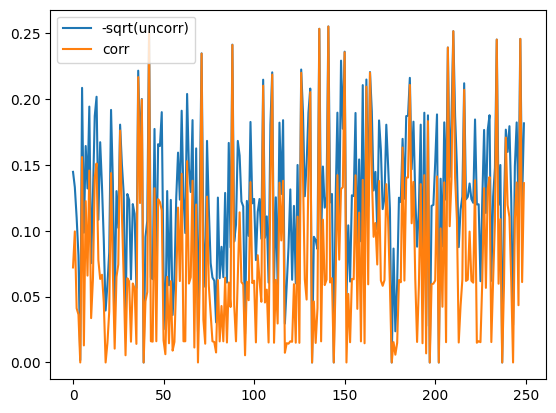

In [84]:
plt.plot(list_uncorr, label='-sqrt(uncorr)')
# plt.plot(sqrt_uncorr, label='sqrt(uncorr)')
plt.plot(list_corr**2, label='corr')
plt.legend()